In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt
import seaborn as sns

## Read data

In [ ]:
path_raw_data = "../data/raw/dataset.csv"
data = pd.read_csv(path_raw_data)

## preprocessing data

In [ ]:
label_encoder = LabelEncoder()
data['weather_main_encoded'] = label_encoder.fit_transform(data['weather_main'])

# Chọn các đặc trưng cần chuẩn hóa
features_to_scale = ['temp', 'pressure', 'grnd_level', 'temp_kf', 'humidity',
                     'probability_of_precipitation', 'value_of_precipitation',
                     'wind_speed', 'wind_deg', 'wind_gust', 'visibility']

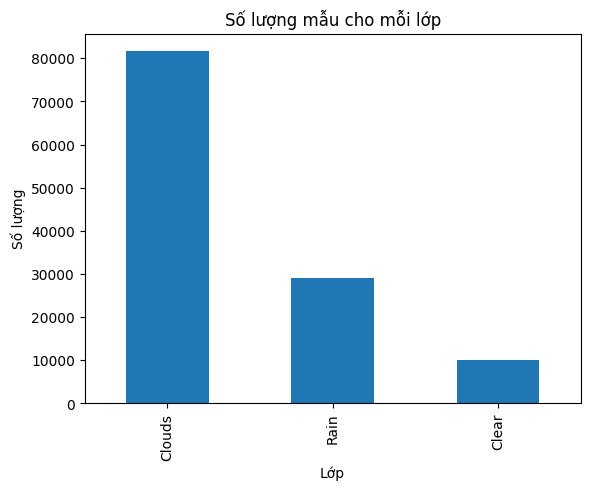

In [ ]:
class_counts = data['weather_main'].value_counts()
class_counts.plot(kind='bar')
plt.title('Số lượng mẫu cho mỗi lớp')
plt.xlabel('Lớp')
plt.ylabel('Số lượng')
plt.show()

In [ ]:
# chuẩn hóa
scaler = StandardScaler()
data[features_to_scale] = scaler.fit_transform(data[features_to_scale])

In [ ]:
citys = list(set(data["city_name"].values))
time_steps = 40
X = []
y = []
for city in citys:
  temp = data[data["city_name"].apply(lambda x: str(x) == city)].sort_values(by="forecast_time_07").reset_index()
  features = temp[features_to_scale].values
  target = temp['weather_main_encoded'].values
  generator = TimeseriesGenerator(features, target, length=time_steps, batch_size=1)
  X += [x[0][0] for x in generator]
  y += [x[1][0] for x in generator]

X = np.array(X)
y = np.array(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Buil model

In [ ]:
# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(64, activation = 'relu', return_sequences=True, input_shape=(time_steps, 11)))
model.add(Dropout(0.2))
model.add(LSTM(64, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 64)            19456     
                                                                 
 dropout (Dropout)           (None, 40, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 52675 (205.76 KB)
Trainable params: 52675 (205.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
label_encoder.classes_

array(['Clear', 'Clouds', 'Rain'], dtype=object)

In [ ]:
class_weights = {
  0: 1.0,  # Lớp "Clear"
  1: 0.2,  # Lớp "Clouds"
  2: 0.6,   # Lớp "Rain"
}
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_split=0.2, class_weight=class_weights)

Epoch 1/30
1182/1182 [==============================] - 85s 72ms/step - loss: 0.1455 - accuracy: 0.7785 - val_loss: 0.5117 - val_accuracy: 0.7658
Epoch 2/30
1182/1182 [==============================] - 78s 66ms/step - loss: 0.1596 - accuracy: 0.7602 - val_loss: 0.5349 - val_accuracy: 0.7495
Epoch 3/30
1182/1182 [==============================] - 83s 70ms/step - loss: 0.1522 - accuracy: 0.7708 - val_loss: 0.5103 - val_accuracy: 0.7661
Epoch 4/30
1182/1182 [==============================] - 79s 67ms/step - loss: 0.1463 - accuracy: 0.7783 - val_loss: 0.5076 - val_accuracy: 0.7655
Epoch 5/30
1182/1182 [==============================] - 84s 71ms/step - loss: 0.1439 - accuracy: 0.7809 - val_loss: 0.5145 - val_accuracy: 0.7667
Epoch 6/30
1182/1182 [==============================] - 78s 66ms/step - loss: 0.1419 - accuracy: 0.7827 - val_loss: 0.5210 - val_accuracy: 0.7661
Epoch 7/30
1182/1182 [==============================] - 81s 68ms/step - loss: 0.1511 - accuracy: 0.7720 - val_loss: 0.5228 -

739/739 [==============================] - 11s 15ms/step
Test Loss: 0.5270573496818542
Test Accuracy: 0.7596613764762878


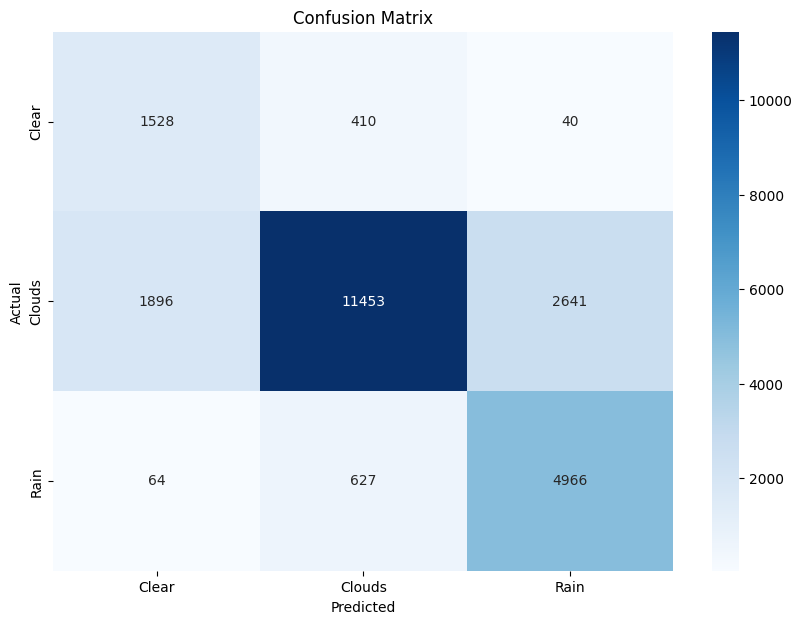

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

loss, accuracy = model.evaluate(X_test, y_test)
predictions = np.argmax(model.predict(X_test), axis=-1)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

confusion_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()